In [22]:
# https://qiita.com/DS27/items/1e998a58488e76bfcbdc
# 必要なライブラリーのインポート
import pandas as pd
import numpy as np

# 統計モデル
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot

# 自作
from util import devide_data
# import util
# import importlib
# importlib.reload(util)

from matplotlib import pylab as plt

# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# データを学習用とテスト用に分割
devide_data('airPassengers', 'csv', 109)# 最後の3年間を予測

       Month  #Passengers
104  1957-09          404
105  1957-10          347
106  1957-11          305
107  1957-12          336
108  1958-01          340
       Month  #Passengers
109  1958-02          318
110  1958-03          362
111  1958-04          348
112  1958-05          363
113  1958-06          435


## ０．データの読み込みとフレームの編集

In [23]:
# データの読み込み
# https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html
df = pd.read_csv('train/AirPassengers.csv')

# float型に変換
df['#Passengers'] = df['#Passengers'].astype('float64')
df = df.rename(columns={'#Passengers': 'Passengers'})

# datetime型にしてインデックスにする
df.Month = pd.to_datetime(df.Month)
df = df.set_index("Month")

# データの中身を確認
# print(df)
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


## １．原系列の観察
* 相関係数からモデル次数を選択

C:\Users\nishida\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


<Figure size 864x576 with 0 Axes>

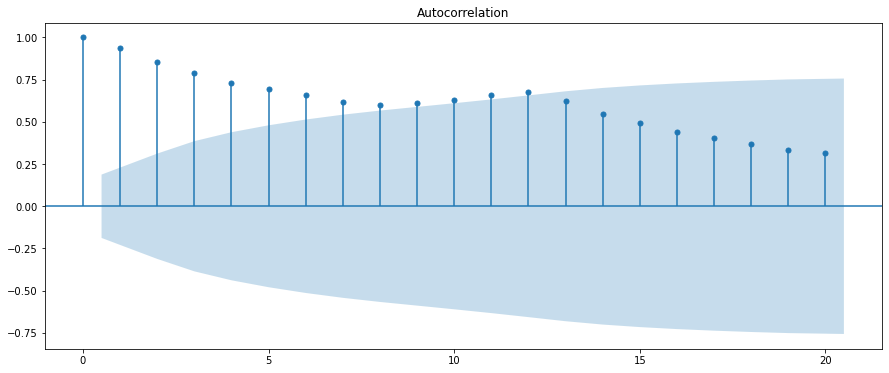

In [26]:
# 自己相関を求める
df_acf = sm.tsa.stattools.acf(df["Passengers"], nlags=20)

# 自己相関のグラフ
# 薄青の空間は、かばん検定の信頼区間95%の範囲
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(df["Passengers"], lags=20)

<Figure size 864x576 with 0 Axes>

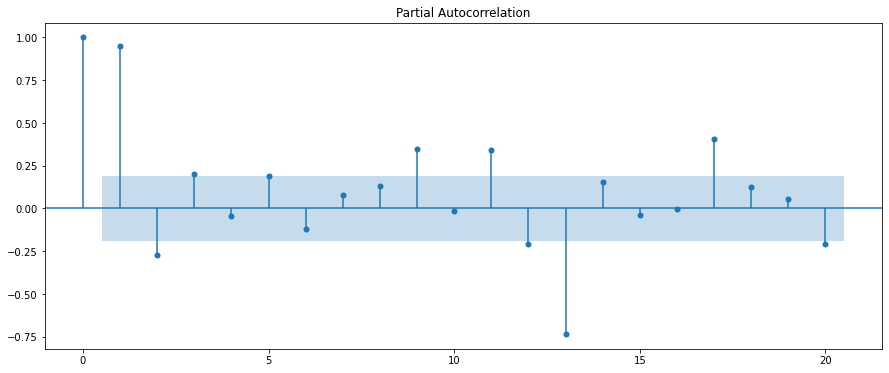

In [27]:
# 偏自己相関を求める
df_pacf = sm.tsa.stattools.pacf(df["Passengers"], nlags=20, method='ols')

# 偏自己相関を可視化する
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.tsa.plot_pacf(df["Passengers"], lags=20)

## ２．単位根検定
A. 　帰無仮説が棄却　→　原系列の予測モデルを作成（→３．）   
B. 　棄却できない　　→　単位根過程？階差系列を取るなど前処理を行い再度単位根検定を実施（→４．）　

In [24]:
# ADF検定：帰無仮説は「時系列は単位根過程である」
sm.tsa.stattools.adfuller(df["Passengers"].values, regression='ctt')
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
# 二つ目の出力が有意水準より高いか

(-2.637585126264857,
 0.49007995604294596,
 13,
 95,
 {'1%': -4.497469532876512,
  '5%': -3.8960771573115616,
  '10%': -3.5924427193468436},
 695.4709829422363)

## ３．ARMAモデルのフィッティングと時系列予測
* 自己相関からMAの次数、偏自己相関からARの次数を決める
* 本来は候補の次数をいくつか挙げ、最終的に情報量基準で決める
* 次数を高くするとフィッティングに失敗しがち、ソルバーが脆弱？

### ２－１．フィッティング

In [66]:
mod = sm.tsa.arima.ARIMA(df["Passengers"].values, order=(13, 0, 7), trend = 'ctt', enforce_stationarity = True)
res = mod.fit()

C:\Users\nishida\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### ２－２．予測

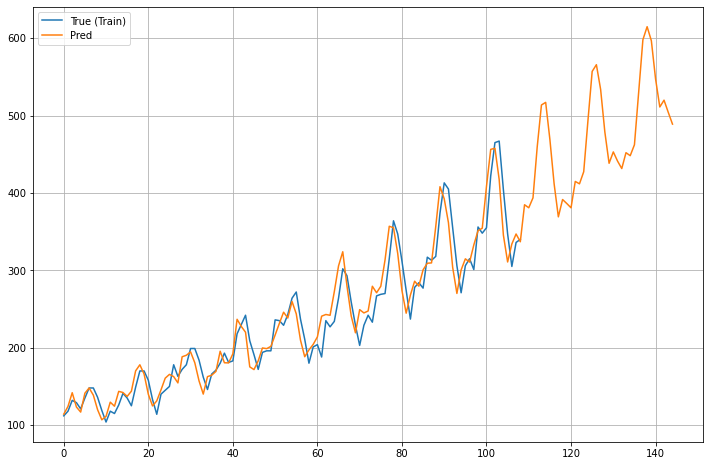

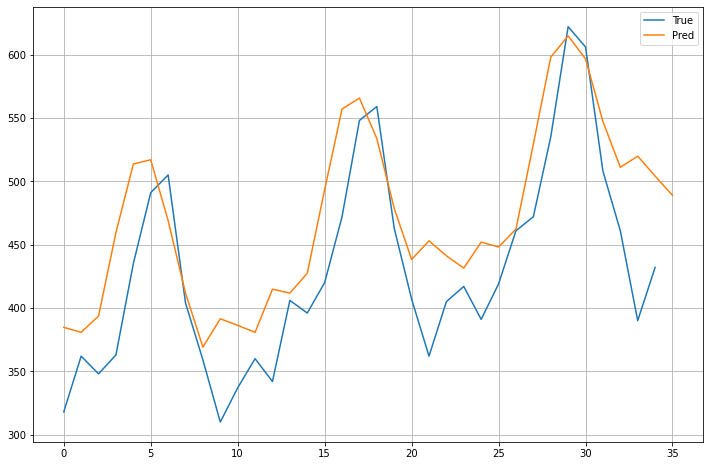

In [67]:
# pred = res.predict()
pred = res.predict(start=1, end=109+3*12)
# print(res.mle_retvals)

fig1 = plt.figure(figsize=(12,8))
plt.plot(df["Passengers"].values, label="True (Train)")
plt.plot(pred, label="Pred")
plt.legend()
plt.grid()

df2 = pd.read_csv('test/AirPassengers.csv')
df2 = df2.rename(columns={'#Passengers': 'Passengers'})
df2.Month = pd.to_datetime(df2.Month)
df2 = df2.set_index("Month")
fig2 = plt.figure(figsize=(12,8))
plt.plot(df2["Passengers"].values, label="True")
plt.plot(pred[109:], label="Pred")
plt.legend()
plt.grid()

## ３．時系列データの前処理
* トレンドや季節変動を除去し、分析対象を定常過程にする
* 例：階差系列、季節調整済みデータなど

### ①　階差系列

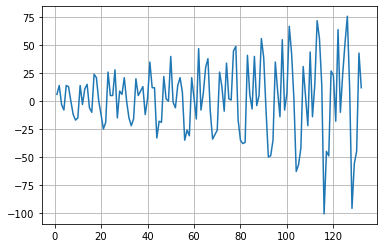

<Figure size 432x288 with 0 Axes>

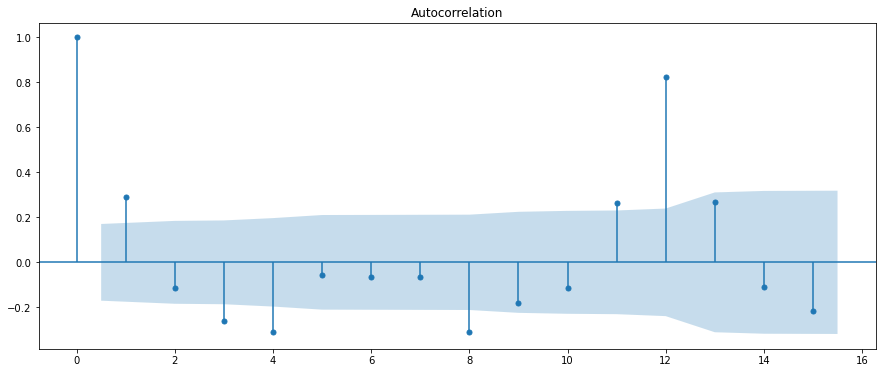

<Figure size 432x288 with 0 Axes>

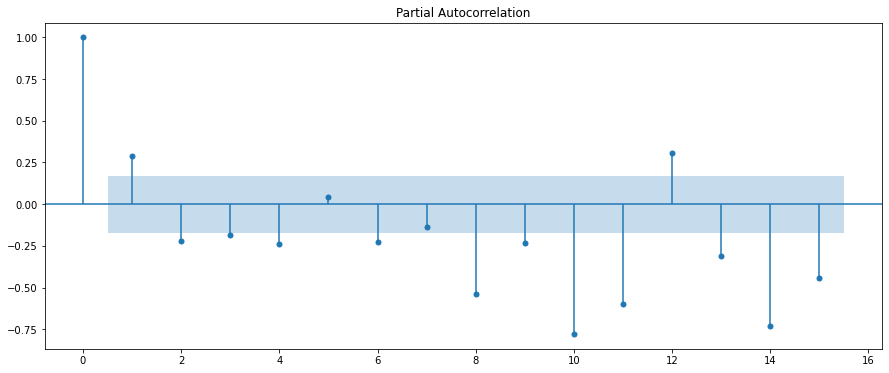

In [20]:
target = df["Passengers"].diff().values

start = 101
period = 1
data_num = 100

fig1 = plt.figure(figsize=(6,4))
fig1 = plt.plot(target)
plt.grid()
plt.show()

# # 自己相関のグラフ
fig2 = plt.figure(figsize=(6,4))
fig2 = sm.graphics.tsa.plot_acf(target[1:], lags=15)
# # 偏自己相関のグラフ
fig3 = plt.figure(figsize=(6,4))
fig3 = sm.graphics.tsa.plot_pacf(target[1:], lags=15)

###　 ②トレンド分解

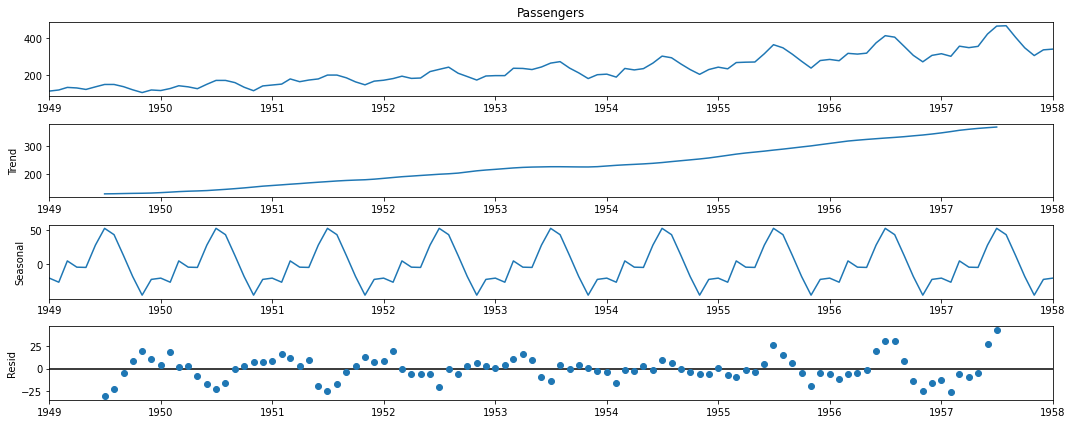

<Figure size 432x288 with 0 Axes>

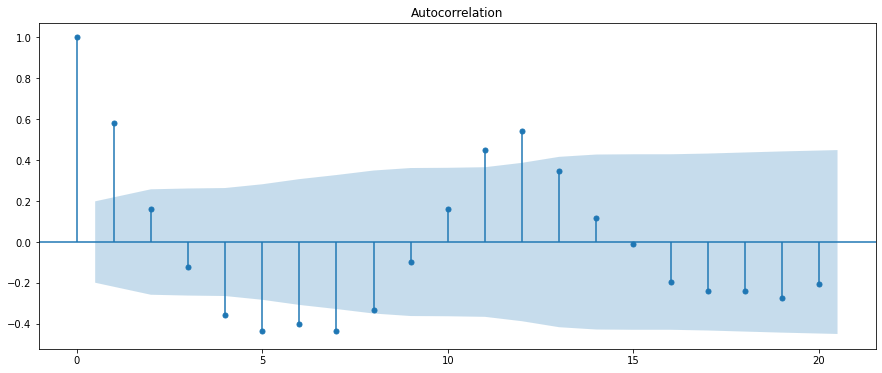

<Figure size 432x288 with 0 Axes>

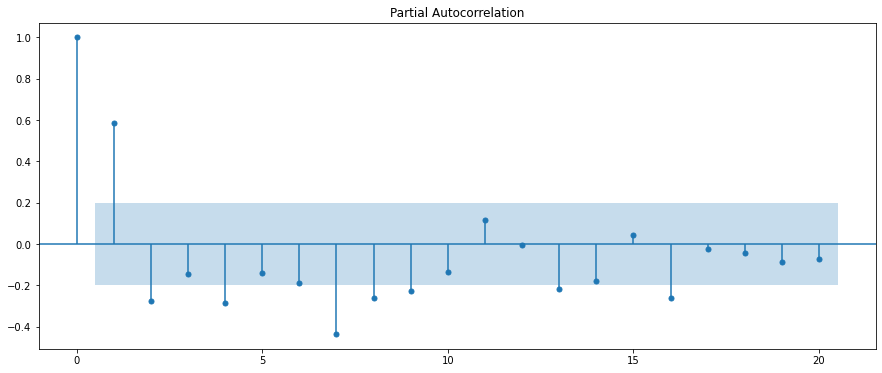

In [60]:
res = sm.tsa.seasonal_decompose(df["Passengers"])
fig = res.plot()

# plt.plot(res.resid)
res.resid
# 自己相関のグラフ
fig2 = plt.figure(figsize=(6,4))
fig2 = sm.graphics.tsa.plot_acf(res.resid[6:-6], lags=20)
# # # 偏自己相関のグラフ
fig3 = plt.figure(figsize=(6,4))
fig3 = sm.graphics.tsa.plot_pacf(res.resid[6:-6], lags=20)

### ④　移動平均

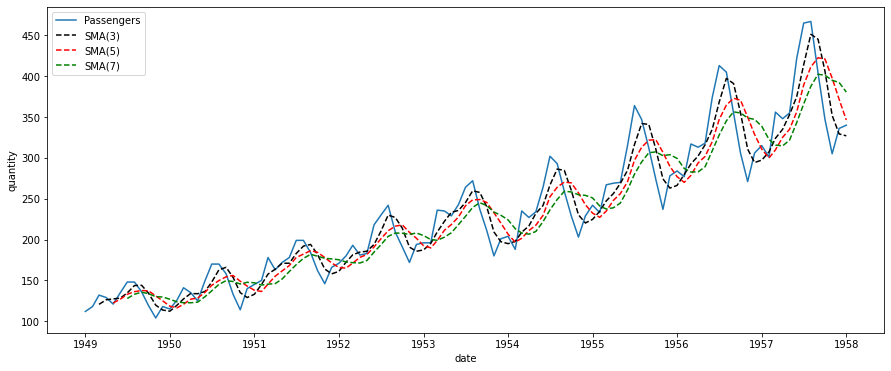

In [48]:
# 移動平均
df["3ma"]=df["Passengers"].rolling(3).mean().round(1)
df["5ma"]=df["Passengers"].rolling(5).mean().round(1)
df["7ma"]=df["Passengers"].rolling(7).mean().round(1)

# 可視化
plt.plot(df["Passengers"], label="Passengers")
plt.plot(df["3ma"], "k--", label="SMA(3)")
plt.plot(df["5ma"], "r--", label="SMA(5)")
plt.plot(df["7ma"], "g--", label="SMA(7)")
plt.xlabel("date")
plt.ylabel("quantity")
plt.legend()

plt.show()